In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l.d2l import d2l

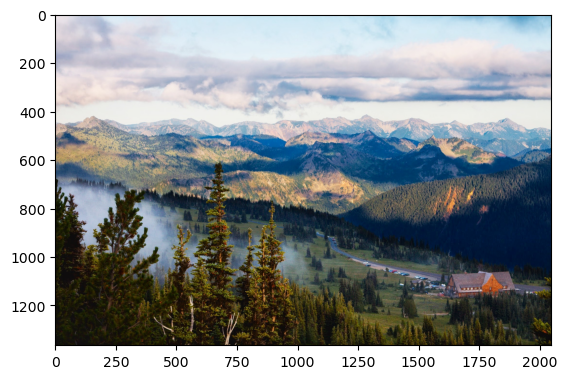

In [2]:
content_img = d2l.Image.open("./imgs/rainier.jpg")
d2l.plt.imshow(content_img)

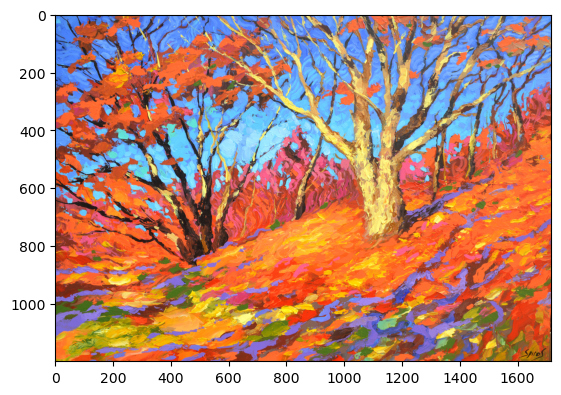

In [4]:
style_img = d2l.Image.open("./imgs/autumn-oak.jpg")
d2l.plt.imshow(style_img)

In [5]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])


def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(image_shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std),
        ]
    )
    return transforms(img).unsqueeze(0)


def postprocess(img):
    img = img[0].to(rgb_std.device)
    # 多维矩阵乘法维度匹配 要进行permute
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [9]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
x = torch.randn(3, 4, 4)
x1 = x.permute(1, 2, 0) * rgb_std + rgb_mean
# x2 = x * rgb_std + rgb_mean

In [10]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

d:\ProgramData\miniforge3\envs\t1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\miniforge3\envs\t1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\hanma/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:09<00:00, 8.28MB/s] 


In [18]:
print(len(list(pretrained_net.named_modules())))
for name, _ in list(pretrained_net.named_modules()):
    print(name)

48

features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
features.31
features.32
features.33
features.34
features.35
features.36
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [47]:
style_layers, content_layers = [5, 11, 18, 25, 32], [8]
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

In [48]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [49]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [50]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标
    # 像素级的值相同
    return torch.square(Y_hat - Y.detach()).mean()

In [51]:
# 风格不需要像素值相似 
# 通过匹配通道统计分布衡量风格损失
from torch import Tensor


def gram(X:torch.Tensor):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    # 均值为0 求协方差 
    # hw值较大时 矩阵中元素会有较大值 除以chw标准化
    return torch.matmul(X, X.T) / (num_channels * n)

In [52]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [53]:
# 全变分损失 尽可能使邻近的像素值相似
def tv_loss(Y_hat):
    return 0.5 * (
        torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean()
        + torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()
    )

In [54]:
content_weight, style_weight, tv_weight = 1, 1e3, 10


def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [55]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [56]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    # 用内容图片作为初始值
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    # 返回初始化的图片参数 预计算的Ygram 优化器
    return gen_img(), styles_Y_gram, trainer

In [57]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

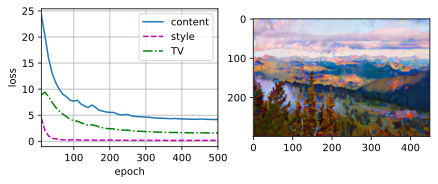

In [58]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)